# Euler's Method for Differential Equations

Suppose we are given the ODE $$\frac{dy}{dx} = F(x, y)$$ <br> and the initial condition $y(x_0) = y_0$, then Euler's Method uses the following recurrence: <br><br>
$$y_{n+1} = y_n + hF(x_n, y_n).$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# General ODE System Solver

Suppose we have a system of $n$ differential equations
$$
\begin{align*}
\frac{dY_1}{dt} &= F_1(t, Y_1, Y_2, \dots, Y_n) \\
\frac{dY_2}{dt} &= F_2(t, Y_1, Y_2, \dots, Y_n) \\
&\vdots \\
\frac{dY_n}{dt} &= F_n(t, Y_1, Y_2, \dots Y_n) \\
\end{align*}
$$

We then simply use Euler's method so that for each $k$, $$(Y_k)_{n+1} = (Y_k)_{n} + hF_k(t, Y_1, Y_2, \dots Y_n) $$

We define a class that solves the ODE using Euler's Method. There are three inputs:
* ```initial_conditions``` is an dictionary with the initial conditions as the values and the variable names as the labels (this is useful, eg. for the SIR model) in the same order as the derivatives. **Note: The first element of this array should be the initial time. This is usually 0**.
* ```times``` is an array with two elements: the start and end time.
* ```functions``` is an array with the derivatives.
An additional useful quantity to store is the number of equations, which is stored in ```self.number_of_equations```. <br><br>


We then define the function that actually solves the differential equations. We first define a matrix with all $0$s. This matrix has a row for each timestep at which we solve the system (plus an additional one for the initial row), as well as a row for each variable (plus an additional one for the times). We then replace the first column with all the timesteps. <br>

We then need to fill each of the remaining rows using the iterative equation given above. If we want to give a function a variable number of inputs, we can use teh ```*``` notation. In this case, ```*iterate``` breaks up the array into its individual elements and passes these as arguments to the function.

In [2]:
class ODE(object):
    def __init__(self, initial_conditions, times, functions):
        self.states = initial_conditions
        self.initial_conditions = list(initial_conditions.values())
        self.times = times
        self.functions = functions
        self.number_of_equations = len(self.functions)
    
    def solve(self, step_size):
        """Initialize matrix with all zeros. The rows are for the timestamps and the columns of the value
        of each Y_k at that time."""
        values = np.zeros((int((self.times[1]-self.times[0])/step_size) + 1, self.number_of_equations + 1))
        values[0] = self.initial_conditions
        
        # Set timestamps
        for i in range(1, values.shape[0]):
            values[i][0] = times[0] + i*step_size
        
        # Apply Euler's Method
        for i in range(1, values.shape[0]):
            iterate = []
            for j in range(self.number_of_equations + 1):
                iterate.append(values[i-1][j])
            for k in range(1, self.number_of_equations + 1):
                values[i][k] = values[i-1][k] + step_size*self.functions[k-1](*iterate)
        
        return values
    
    
    
    def plot(self, output, multiple=False, phase=False):
        if multiple == True:
            fig, axs = plt.subplots(self.number_of_equations, 1, figsize=(10,10))
            for i in range(1, len(self.functions)+1):
                axs[i-1].scatter(output[:, 0], output[:, i], s = 1)
                axs[i-1].set_xlabel(list(self.states.keys())[0])
                axs[i-1].set_ylabel(list(self.states.keys())[i])
        elif multiple == False and phase == False:
            for i in range(1, len(self.functions)+1):
                #plt.scatter(output[:, 0], output[:, i], s = 1, label = list(self.states.keys())[i])
                plt.plot(output[:, 0], output[:, i], label=list(self.states.keys())[i], linewidth=1)
        else:
            if self.number_of_equations > 2:
                return "Error"
            else:
                dat = np.zeros((output.shape[0], 2))
                
                dat[:,0] = output[:,1]
                dat[:,1] = output[:,2]
                
                plt.xlabel(list(self.states.keys())[1])
                plt.ylabel(list(self.states.keys())[2])
                plt.plot(dat[:,0], dat[:,1])
            
        
        plt.legend(loc=2)    
        plt.show()

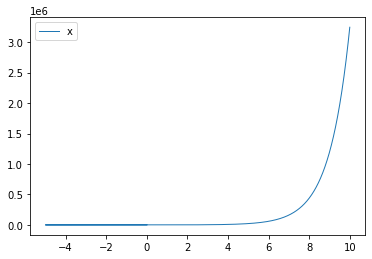

In [3]:
def dxdt(t, x):
    return x

functions = [dxdt]

initial_conditions = {"t": 0.00, "x": 1.00}
times = [-5.00, 10.00]

equations = ODE(initial_conditions, times, functions)
output = equations.solve(0.001)
equations.plot(output)

# SIR Model for Infectious Diseases

The SIR Model is a compartmental model for infectious diseases. The population is split into three compartments: "susceptible", "infectious" and "recovered" (sometimes "removed"). How the number of people in each compartment changes over time is given by the following system of differential equations.

$$
\begin{align*}
\frac{dS}{dt} &= -\frac{\beta IS}{N} \\
\frac{dI}{dt} &= \frac{\beta IS}{N} - \gamma I \\
\frac{dR}{dt} &= \gamma I,
\end{align*}
$$ where $N = S + I + R$ is the total population. <br><br>
There are two parameters for the simple model given above: $\beta$ and $\gamma$.
* $\beta$ is the infection rate: the number of secondary infections per unit time.
* $\gamma$ is the recovery rate. Indeed, $\frac{1}{\gamma}$ is the average duration of the infectious period.

In [4]:
class SIR(ODE):
    def __init__(self, initial_conditions, times, parameters):
        self.states = initial_conditions
        self.initial_conditions = list(initial_conditions.values())
        self.times = times
        self.parameters = parameters
        self.number_of_equations = len(self.initial_conditions) - 1
    
    def model(self):
        def dS(t, S, I, R):
            N = S + I + R
            return -(self.parameters["beta"]*I*S)/N
        def dI(t, S, I, R):
            N = S + I + R
            return ((self.parameters["beta"]*I*S)/N) - self.parameters["gamma"]*I
        def dR(t, S, I, R):
            N = S + I + R
            return self.parameters["gamma"]*I
        
        self.functions = [dS, dI, dR]

In [5]:
from ipywidgets import interactive

#initial_conditions = {"t": 0.00, "S": 1000.00, "I": 1.00, "R": 0.00}
#times = [0, 100.00]
#parameters = {"beta": 0.4, "gamma": 0.2}

def SIR_Model(beta, gamma=0): 
    initial_conditions = {"t": 0.00, "S": 1000.00, "I": 1.00, "R": 0.00}
    times = [0, 100.00]
    parameters = {"beta": beta, "gamma": gamma}
    sir_model = SIR(initial_conditions, times, parameters)
    sir_model.model()
    output = sir_model.solve(0.01)
    sir_model.plot(output)
    
iplot = interactive(SIR_Model, beta=(0, 1, 0.1), gamma=(0,2,0.1))
iplot

interactive(children=(FloatSlider(value=0.0, description='beta', max=1.0), FloatSlider(value=0.0, description=…